# Kaggle
## Competição DSA de Machine Learning - Dezembro 2019

Versão 1.0.0: LB = 0.50557
- modelo: XGBoost (com algumas otimizações)
- features categoricas: removido
- dados missing: atribuído o valor medio

Versão 1.0.1: LB = 0.48972 / CV = 0.469777
- modelo: XGBoost executando todas as otimizações
- features engineering: gerado através do Auto_ViML

Versão 1.0.2: LB = 0.55264 / CV = 0.469158
- modelo: XGBoost executando todas as otimizações
- dados missing: removido colunas com mais de 40% de NA e as demais -999
- features categoricas: label encoder
- feature engineering: usando pacote Boruta

Versão 1.0.3: LB = ??? / CV = ???
- modelo: XGBoost executando todas as otimizações
- features engineering: gerado através do Auto_ViML (modificado v1)

Versão 1.0.4: LB = 0.49299 / CV = 0.470500
- modelo: XGBoost executando todas as otimizações
- features engineering: Kernel_Feature_Engineering_v.1.0.0

Versão 1.0.5: LB = ???? / CV = 0.470085 - 0.470368 - 0.474402 - 0.476252 - 0.476149
- modelo: XGBoost executando todas as otimizações
- features engineering: Dentro deste notebook

## 1. Importando as bibliotecas

In [15]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import time
import datetime
import gc

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [16]:
# Importa os pacotes de algoritmos
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb

# Importa pacotes do sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

## 2. Carregando os dados de treino e teste

In [17]:
def read_data():
    
    if TRAIN_OFFLINE:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('../dataset/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_teste.csv....')
        test = pd.read_csv('../dataset/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
        
    else:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_treino.csv....')
        test = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
    
    return train, test

In [60]:
# Leitura dos dados
train, test = read_data()

Carregando arquivo dataset_treino.csv....
dataset_treino.csv tem 114321 linhas and 133 colunas
Carregando arquivo dataset_teste.csv....
dataset_teste.csv tem 114393 linhas and 132 colunas


In [124]:
df = train.append(test)

In [125]:
# Verificar a quantidade de features numericas e categoricas

numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  114
Number of Categorical features:  19


# Feature Engineering

In [126]:
# Removendo alguns outliers
df = df[df['v129'] <= 2]
df = df[df['v3'] == 'C']

In [127]:
# Ajustando o skewness de algumas features com logaritmo
df["v19"]  = np.log1p(df["v19"])
df["v105"] = np.log1p(df["v105"])
df["v119"] = np.log1p(df["v119"])
df["v124"] = np.log1p(df["v124"])
df["v23"]  = np.log1p(df["v23"])
df["v39"]  = np.log1p(df["v39"])
df["v68"]  = np.log1p(df["v68"])

In [128]:
# Remove colunas com alta correlacao entre si ou com mais de 95% com zeros
#df = df.drop(columns = ['v12','v128','v13','v25','v32','v33','v34','v38','v41','v43','v46',
#                           'v49','v53','v54','v55','v60','v63','v64','v65','v67','v73','v76','v77',
#                           'v8','v83','v87','v89','v95','v96','v97'], axis = 1)

In [129]:
# Transformando as features categorias com LabelEncoder
le = LabelEncoder()

for i, col in enumerate(df):
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(np.array(df[col].astype(str)).reshape((-1,)))

In [130]:
scaler = StandardScaler()
for c in df.columns:
    col_type = df[c].dtype
    #if col_type == 'float64' and c != 'target':
    if c != 'ID' and c != 'target':
        df[c] = scaler.fit_transform(df[c].values.reshape(-1, 1))

In [131]:
# Realizando tratamento de missing value
for c in df.columns:
    if c != 'ID' and c != 'target':
        df[c].fillna(df[c].median(),inplace=True)

In [132]:
# Add decomposed components: PCA / ICA etc.
n_comp = 12

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=42)
tsvd_results_df = tsvd.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca2_results_df = pca.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

# ICA
ica = FastICA(n_components=n_comp, random_state=42)
ica2_results_df = ica.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=42)
grp_results_df = grp.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=42)
srp_results_df = srp.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

In [133]:
# Append decomposition components to datasets
for i in range(1, n_comp+1):
    df['pca_' + str(i)]  = pca2_results_df[:,i-1]
    df['ica_' + str(i)]  = ica2_results_df[:,i-1]
    df['tsvd_' + str(i)] = tsvd_results_df[:,i-1]
    df['grp_' + str(i)]  = grp_results_df[:,i-1]
    df['srp_' + str(i)]  = srp_results_df[:,i-1] 

In [183]:
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)
poly_features = df[['v62', 'v119', 'v123', 'v48', 'v85']]

# imputer for handling missing values
imputer = SimpleImputer(strategy = 'median')

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)

# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)

print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (217600, 56)


In [184]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['v62', 'v119', 'v123', 'v48', 'v85']))

poly_features = poly_features.drop(columns = ['1'], axis = 1)

poly_features.index = df.index
df.shape, poly_features.shape

((217600, 193), (217600, 55))

In [185]:
# Merge polynomial features into training dataframe
poly_features['ID'] = df['ID']
new_df = df.merge(poly_features, on = 'ID', how = 'left')

In [187]:
print(new_df.shape)
new_df.head()

(217600, 193)


,ID,target,v1,v10,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v11,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v12,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v13,v130,v131,v14,v15,v16,v17,v18,v19,v2,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v3,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v4,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v5,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v6,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v7,v70,v71,v72,v73,v74,v75,v76,v77,v78,v79,v8,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v9,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99,pca_1,ica_1,tsvd_1,grp_1,srp_1,pca_2,ica_2,tsvd_2,grp_2,srp_2,pca_3,ica_3,tsvd_3,grp_3,srp_3,pca_4,ica_4,tsvd_4,grp_4,srp_4,pca_5,ica_5,tsvd_5,grp_5,srp_5,pca_6,ica_6,tsvd_6,grp_6,srp_6,pca_7,ica_7,tsvd_7,grp_7,srp_7,pca_8,ica_8,tsvd_8,grp_8,srp_8,pca_9,ica_9,tsvd_9,grp_9,srp_9,pca_10,ica_10,tsvd_10,grp_10,srp_10,pca_11,ica_11,tsvd_11,grp_11,srp_11,pca_12,ica_12,tsvd_12,grp_12,srp_12
0,3,1.0,-0.275654,-0.987378,1.067835,0.674750,-0.058035,-0.759300,-1.209903,-0.786148,0.288279,1.181801,0.278535,-0.046171,1.258236,1.024331,-1.974168,0.889489,0.864307,0.769349,-4.055820,-0.503088,-0.453998,-1.214172,-1.221152,-0.858905,-0.316689,-1.430060,0.655249,-0.605648,-0.654965,-0.972244,0.254044,-0.078336,0.016498,-0.466762,-0.793909,-1.023106,0.995685,-0.268430,-0.998675,2.044445,-0.060052,-1.130556,-0.850814,0.442069,0.955301,0.705230,1.405509,-0.317665,-0.963439,-0.527301,-0.268266,0.783797,-1.671470,0.539102,0.0,-1.294630,-0.453732,-0.960028,-1.175528,0.428994,0.197948,-0.885709,-0.544293,-0.155959,1.734702,-0.177018,-0.844050,0.482030,-0.215068,-0.303230,-0.121756,0.338058,-0.523561,-0.943312,-0.191223,0.083027,-0.390014,-0.493190,0.012067,0.126864,1.301914,-0.527220,-0.322817,0.500024,-0.159813,-1.044822,0.162719,0.280774,-0.220197,0.606402,-0.112236,-0.516334,0.033841,1.313802,1.661200,0.034902,-0.715188,4.054921,1.172564,-0.199172,0.701259,-0.517205,-1.036249,-0.073551,0.714585,-0.103087,-0.000794,-2.592016,0.224784,-0.532054,0.720065,0.092164,0.710813,-1.438321,-0.342150,-0.786954,-0.755194,-0.189619,1.346015,-0.507331,0.493548,-0.316868,-1.117668,-0.523471,0.238570,-0.401760,-0.707347,0.888226,-1.112682,0.513062,-0.110201,-3.667229,-0.002515,-4.010123,0.743704,-1.731576,-2.941824,-0.001233,-3.340147,2.023942,-7.100143,-0.914768,-0.001271,-1.027213,-0.645408,-2.376196,0.123429,-0.000163,0.126518,-5.010834,1.850191,0.829152,-0.000035,0.828171,-1.061037,-2.429591,-0.873181,-0.001291,-0.854297,-1.833172,0.625513,-0.603193,-0.000838,-0.611584,1.946043,0.327741,-0.900765,-0.002355,-0.838076,2.615794,-2.558668,1.251254,0.000944,1.217440,-2.025024,-0.617287,0.882000,-0.002000,0.746641,3.924714,-5.547656,0.692686,0.002149,0.497466,3.380343,1.334592,-1.655516,0.000147,-1.077740,-5.177747,3.860268
1,4,1.0,-0.152544,-0.361247,0.347878,-0.096819,-0.234845,-0.143543,-0.149729,0.754226,0.105368,-0.949382,-0.345458,0.040973,0.059764,-0.976247,-0.173830,1.905236,-0.802408,-1.267794,-0.036461,-0.096978,0.657217,-0.112657,-0.157795,-0.366415,-0.200869,-0.222199,-0.041031,-0.316561,0.105700,-1.562948,-0.115163,-0.167718,-0.047083,-0.466762,-0.172713,-0.292016,-0.134309,-0.268431,-0.124982,0.009864,-0.136239,-0.106147,-0.237748,-0.153884,0.233301,-0.230905,-0.285847,-0.317664,-0.963439,0.479715,-0.093490,-0.082764,-0.019236,0.071174,0.0,-1.294630,-0.453732,-0.117536,-0.220666,-1.360801,-0.036843,0.504732,-0.186837,-0.155959,-0.385545,0.058662,1.240442,0.022154,0.012366,-0.097738,-0.001877,0.005302,0.296723,-0.423033,-0.065618,0.007337,0.234703,-0.071136,-0.029223,0.126864,0.075014,-0.042617,-0.225531,1.000102,-0.014516,-0.347035,-0.030960,-0.040551,-0.087151,0.236496,1.368007,0.303106,-0.081848,0.222002,-0.748262,0.025196,0.292346,0.033579,-0.053059,-0.083837,0.701259,0.684646,-0.128398,-0.073551,0.714585,-0.158709,0.051393,-0.000125,-0.153407,0.298332,-0.112075,-0.020537,-0.759959,-0.221131,-0.197192,-0.164700,-0.135502,-0.090769,-0.155783,0.436395,0.016196,0.006097,-0.687424,-0.150764,-0.099318,-0.12

# Feature Selection

In [188]:
treino = new_df[new_df['target'].notnull()]
teste = new_df[new_df['target'].isnull()]

In [189]:
# Importância do Atributo com o Random Forest Regressor
X_ = treino.drop(['ID','target'], axis=1)
y_ = treino['target']

# Criação do Modelo - Feature Selection
modeloRF = RandomForestClassifier(bootstrap=False, 
                                 max_features=0.3, 
                                 min_samples_leaf=15, 
                                 min_samples_split=8, 
                                 n_estimators=50, 
                                 n_jobs=-1, 
                                 random_state=42)
modeloRF.fit(X_, y_)

# Convertendo o resultado em um dataframe
feature_importance_df = pd.DataFrame(treino.drop(['ID','target'], axis=1).columns,columns=['Feature'])
feature_importance_df['importance'] = pd.DataFrame(modeloRF.feature_importances_.astype(float))

# Realizando a ordenacao por Importancia (Maior para Menor)
result = feature_importance_df.sort_values('importance',ascending=False)
print(result)

    Feature  importance
77      v50    0.160437
94      v66    0.044160
148  tsvd_4    0.019601
180  srp_10    0.017454
56      v31    0.017445
..      ...         ...
196   v62^2    0.000132
191   v62_y    0.000106
103     v74    0.000098
104     v75    0.000063
54       v3    0.000000

[246 rows x 2 columns]


In [1]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(18,16))
sns.barplot(x="importance",
           y="Feature",
           data=best_features.sort_values(by="importance",
                                          ascending=False))
plt.title('Importance Features')
plt.tight_layout()

NameError: name 'feature_importance_df' is not defined

# Algoritmo XGBoost - Extreme Gradient Boosting

In [193]:
train_x = treino.loc[:,best_features['Feature']]

#train_x = new_df.drop(['ID','target'], axis=1)
train_y = treino['target']

In [196]:
# Criando uma funcao para criação, execução e validação do modelo
def run_model(modelo, X_tr, y_tr, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    # Utilização do Cross-Validation
    if useTrainCV:
        xgb_param = modelo.get_xgb_params()
        xgtrain = xgb.DMatrix(X_tr, label=y_tr)
        
        print ('Start cross validation')
        cvresult = xgb.cv(xgb_param, 
                          xgtrain, 
                          num_boost_round=modelo.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics=['logloss'],
                          stratified=True,
                          seed=42,
                          verbose_eval=True,
                          early_stopping_rounds=early_stopping_rounds)

        modelo.set_params(n_estimators=cvresult.shape[0])
        best_tree = cvresult.shape[0]
        print('Best number of trees = {}'.format(best_tree))
    
    # Fit do modelo
    modelo.fit(X_tr, y_tr, eval_metric='logloss')
        
    # Predição no dataset de treino
    train_pred = modelo.predict(X_tr)
    train_pred_prob = modelo.predict_proba(X_tr)[:,1]
    
    # Exibir o relatorio do modelo
    print("Log Loss (Treino): %f" % log_loss(y_tr, train_pred_prob))
    print("Log Loss (Test): %f" % cvresult['test-logloss-mean'][best_tree-1])
    
    feature_imp = pd.Series(modelo.feature_importances_.astype(float)).sort_values(ascending=False)
    
    plt.figure(figsize=(18,8))
    feature_imp[:25].plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.tight_layout()

Start cross validation
[0]	train-logloss:0.663383+6.30447e-05	test-logloss:0.66347+8.00825e-05
[1]	train-logloss:0.636801+0.00163639	test-logloss:0.637047+0.0016703
[2]	train-logloss:0.614454+0.00216622	test-logloss:0.614841+0.00213348
[3]	train-logloss:0.596514+0.0030592	test-logloss:0.597002+0.00299571
[4]	train-logloss:0.58038+0.00332493	test-logloss:0.58096+0.00324102
[5]	train-logloss:0.566208+0.00278919	test-logloss:0.566883+0.00271905
[6]	train-logloss:0.554927+0.00264823	test-logloss:0.555713+0.00239686
[7]	train-logloss:0.545195+0.00257083	test-logloss:0.546056+0.00224053
[8]	train-logloss:0.537133+0.00189622	test-logloss:0.538091+0.00156745
[9]	train-logloss:0.529865+0.00228215	test-logloss:0.530957+0.00184232
[10]	train-logloss:0.52418+0.00267926	test-logloss:0.525361+0.00226698
[11]	train-logloss:0.518216+0.00244394	test-logloss:0.519491+0.00199036
[12]	train-logloss:0.513532+0.00191609	test-logloss:0.514902+0.00139804
[13]	train-logloss:0.509909+0.00194559	test-logloss:0.5

[113]	train-logloss:0.461417+0.000554279	test-logloss:0.475992+0.00118672
[114]	train-logloss:0.461231+0.000597616	test-logloss:0.475933+0.00118189
[115]	train-logloss:0.461051+0.000605212	test-logloss:0.475878+0.00115217
[116]	train-logloss:0.460903+0.000641382	test-logloss:0.475854+0.0011886
[117]	train-logloss:0.460773+0.000631005	test-logloss:0.475838+0.00117832
[118]	train-logloss:0.46061+0.000652976	test-logloss:0.475797+0.00121162
[119]	train-logloss:0.460473+0.000647139	test-logloss:0.475792+0.00121748
[120]	train-logloss:0.460309+0.000639533	test-logloss:0.475748+0.00121454
[121]	train-logloss:0.460136+0.000619872	test-logloss:0.475742+0.0012037
[122]	train-logloss:0.460025+0.0006255	test-logloss:0.475732+0.00118806
[123]	train-logloss:0.459874+0.00061395	test-logloss:0.475707+0.00116905
[124]	train-logloss:0.459743+0.000595572	test-logloss:0.475665+0.00116304
[125]	train-logloss:0.459611+0.000600082	test-logloss:0.47566+0.00116859
[126]	train-logloss:0.459457+0.000569848	test

[225]	train-logloss:0.446359+0.000520969	test-logloss:0.47476+0.00128663
[226]	train-logloss:0.446235+0.00053548	test-logloss:0.474778+0.00129534
[227]	train-logloss:0.446094+0.00052892	test-logloss:0.474766+0.00130571
[228]	train-logloss:0.445958+0.000522153	test-logloss:0.474755+0.00129786
[229]	train-logloss:0.44581+0.000527953	test-logloss:0.474749+0.00129802
[230]	train-logloss:0.445702+0.000541037	test-logloss:0.474759+0.0013004
[231]	train-logloss:0.445575+0.00057138	test-logloss:0.474748+0.00131929
[232]	train-logloss:0.445464+0.000552612	test-logloss:0.474776+0.00131922
[233]	train-logloss:0.445341+0.000542279	test-logloss:0.474751+0.00132756
[234]	train-logloss:0.445216+0.000546227	test-logloss:0.474726+0.00133378
[235]	train-logloss:0.445089+0.00052914	test-logloss:0.474723+0.00134252
[236]	train-logloss:0.444974+0.000536089	test-logloss:0.474723+0.00135666
[237]	train-logloss:0.444847+0.000546238	test-logloss:0.474749+0.00137891
[238]	train-logloss:0.444692+0.000536399	test

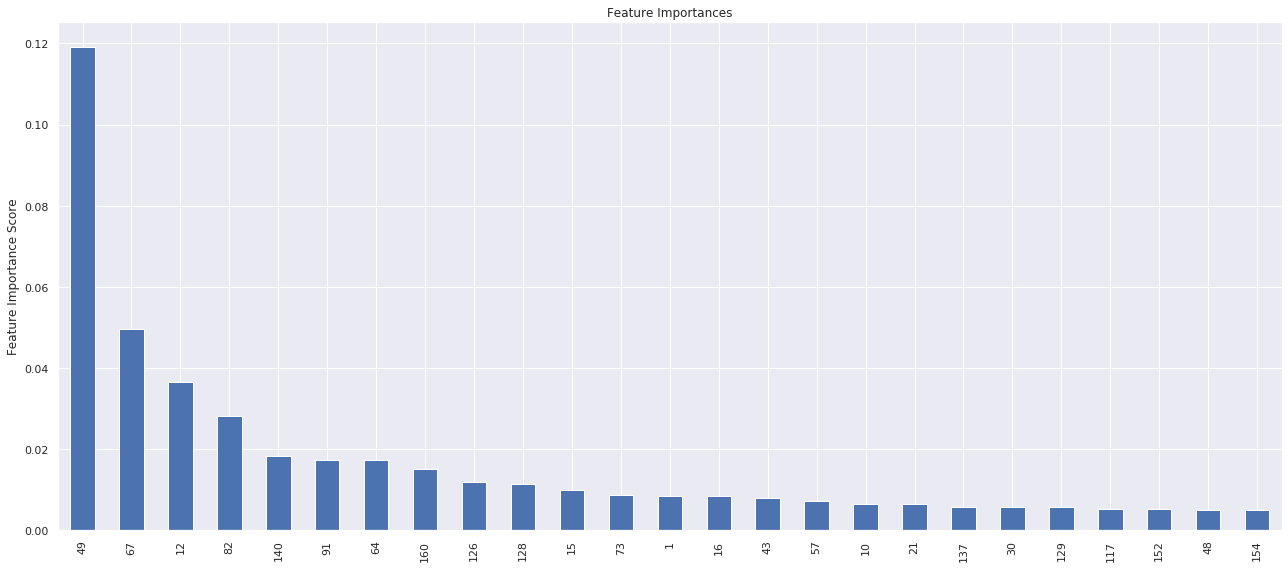

In [197]:
%%time

# Criando o modelo XGB com todas as otimizações
modeloXGB_v2 = XGBClassifier(learning_rate = 0.1, 
                             n_estimators = 1000, 
                             max_depth = 4,
                             min_child_weight = 1, 
                             gamma = 0, 
                             subsample = 0.7, 
                             colsample_bytree = 0.6,
                             reg_alpha = 0.005,
                             objective = 'binary:logistic', 
                             n_jobs = -1,
                             scale_pos_weight = 1, 
                             seed = 42)

run_model(modeloXGB_v2, train_x, train_y)

In [198]:
# Visualizando o modelo XGBoost Otimizado
print(modeloXGB_v2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=301, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.7, verbosity=1)


In [201]:
# Predição no dataset de treino
#train_pred = modelo.predict(train_x)
train_pred_prob = modeloXGB_v2.predict_proba(train_x)[:,1]

In [209]:
calibrator = CalibratedClassifierCV(modeloXGB_v2,method='isotonic',cv=2)
calibrator.fit(train_x, train_y)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=0.6,
                                                    gamma=0, learning_rate=0.1,
                                                    max_delta_step=0,
                                                    max_depth=4,
                                                    min_child_weight=1,
                                                    missing=None,
                                                    n_estimators=301, n_jobs=-1,
                                                    nthread=None,
                                                    objective='binary:logistic',
                                                    random_sta

In [211]:
y_preds = calibrator.predict_proba(train_x)
preds = y_preds[:,1]

# also predict discrete labels for comparison
discrete_preds = calibrator.predict(train_x)

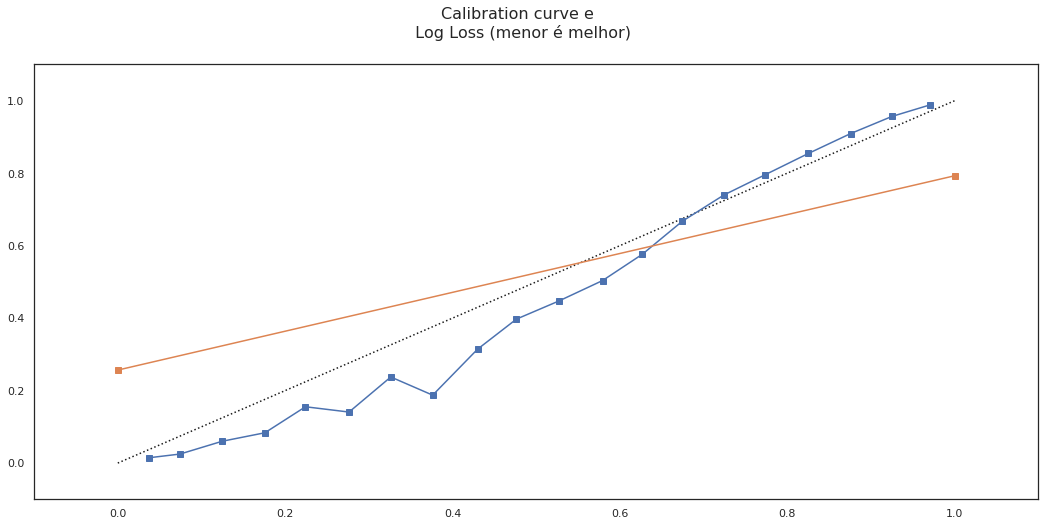

In [222]:
from sklearn.metrics import brier_score_loss

## PLOT CURVE
# Setup do plot
sns.set_style("white")
f, ax = plt.subplots(figsize=(18, 8))
sns.set_color_codes(palette='deep')

plt.clf()

ax = plt.gca()

ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.1,1.1])

ax.plot([0, 1], [0, 1], "k:", label="Perfect calibration")

clf_score = brier_score_loss(train_y, preds, pos_label=1)
fraction_of_positives, mean_predicted_value = calibration_curve(train_y, preds, n_bins=20)
ax.plot(mean_predicted_value, fraction_of_positives, "s-", label="Sigmoid Calibration (Brier loss={:.2f})".format(clf_score))

clf_score = brier_score_loss(train_y, discrete_preds, pos_label=1)
fraction_of_positives, mean_predicted_value = calibration_curve(train_y, discrete_preds, n_bins=20)
ax.plot(mean_predicted_value, fraction_of_positives, "s-", label="Discrete predictions (Brier loss={:.2f})".format(clf_score))

plt.suptitle('Calibration curve e \n Log Loss (menor é melhor)', size=16)
plt.show()

## 5. Submissions

In [223]:
teste.head()

,ID,target,v1,v10,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v11,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119_x,v12,v120,v121,v122,v123_x,v124,v125,v126,v127,v128,v129,v13,v130,v131,v14,v15,v16,v17,v18,v19,v2,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v3,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v4,v40,v41,v42,v43,v44,v45,v46,v47,v48_x,v49,v5,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v6,v60,v61,v62_x,v63,v64,v65,v66,v67,v68,v69,...,pca_4,ica_4,tsvd_4,grp_4,srp_4,pca_5,ica_5,tsvd_5,grp_5,srp_5,pca_6,ica_6,tsvd_6,grp_6,srp_6,pca_7,ica_7,tsvd_7,grp_7,srp_7,pca_8,ica_8,tsvd_8,grp_8,srp_8,pca_9,ica_9,tsvd_9,grp_9,srp_9,pca_10,ica_10,tsvd_10,grp_10,srp_10,pca_11,ica_11,tsvd_11,grp_11,srp_11,pca_12,ica_12,tsvd_12,grp_12,srp_12,v62_y,v119_y,v123_y,v48_y,v85_y,v62^2,v62 v119,v62 v123,v62 v48,v62 v85,v119^2,v119 v123,v119 v48,v119 v85,v123^2,v123 v48,v123 v85,v48^2,v48 v85,v85^2,v62^3,v62^2 v119,v62^2 v123,v62^2 v48,v62^2 v85,v62 v119^2,v62 v119 v123,v62 v119 v48,v62 v119 v85,v62 v123^2,v62 v123 v48,v62 v123 v85,v62 v48^2,v62 v48 v85,v62 v85^2,v119^3,v119^2 v123,v119^2 v48,v119^2 v85,v119 v123^2,v119 v123 v48,v119 v123 v85,v119 v48^2,v119 v48 v85,v119 v85^2,v123^3,v123^2 v48,v123^2 v85,v123 v48^2,v123 v48 v85,v123 v85^2,v48^3,v48^2 v85,v48 v85^2,v85^3
108764,0,NaN,-0.238747,-0.361246,1.102409,-1.128910,-0.554607,-0.958038,-1.065255,-0.790785,-0.013626,-0.949382,-0.706957,-0.543624,1.788995,-0.976247,0.121392,1.905236,0.864307,-0.526398,0.465959,-1.514045,-0.957544,-1.252120,-1.221152,0.162947,0.223045,0.373045,0.442710,-0.671904,-0.716509,-1.562948,-0.756671,0.407194,-0.498534,-0.466762,-0.589041,0.309191,-0.267249,0.159978,-0.428208,-1.166379,-0.154414,-1.145764,0.075114,1.335232,0.133446,0.421707,-1.170338,-0.317663,0.833800,-0.551549,-1.653800,1.978767,-1.677821,-0.930375,0.0,0.842251,-0.453732,-0.903121,-0.095309,-0.570747,0.049971,-0.519543,0.173139,-0.155959,1.299779,0.067406,0.433999,-0.405034,-2.080085,-1.419206,-0.066934,0.128668,-0.528153,1.658084,0.084399,-0.560143,-1.045216,-1.179833,0.534639,-1.035821,1.644642,-0.524019,-0.276778,-1.800334,-2.186331,-1.079632,-0.733432,-0.587497,-1.647333,0.163383,-0.112236,-0.537579,-0.124867,-0.107053,-0.748262,-1.111112,-0.474351,-0.464533,...,0.100421,0.004274,0.174170,1.427740,-1.053560,-3.082852,7.953783e-07,-3.179227,-1.632919,-3.388920,-2.375512,-0.000535,-2.365331,1.142744,-0.979851,-3.694889,-0.001546,-3.636046,-3.521182,4.904838,1.544305,-0.001875,1.588545,-2.453809,-1.301361,1.222347,0.002014,1.194978,-3.929639,2.019373,0.489892,-0.004529,0.670439,-2.207284,-2.650498,-2.036162,0.000045,-1.337518,-3.087443,1.973887,-1.411583,-0.005704,-1.671580,2.429697,-0.541494,-0.112236,-1.221152,-0.671904,0.084399,-0.679550,0.012597,0.137057,0.075412,-0.009473,0.076270,1.491212,0.820497,-0.103064,0.829834,0.451455,-0.056708,0.456592,0.007123,-0.057353,0.461788,-0.001414,-0.015383,-0.008464,0.001063,-0.008560,-0.167368,-0.092089,0.011567,-0.093137,-0.050669,0.006365,-0.051246,-0.000799,0.006437,-0.051829,-1.820997,-1.001951,0.125857,-1.013353,-0.551295,0.069249,-0.557568,-0.008698,0.070037,-0.563913,-0.303334,0.038102,-0.306786,-0.004786,0.038536,-0.310277,0.000601,-0.004841,0.038974,-0.313808
108765,1,NaN,-0.152544,-0.378168,0.347878,-0.096819,-0.234845,-0.143543,-0.149729,-0.437881,0.105368,0.471407,-0.190475,-0.299420,0.059764,1.024331,-0.173830,-0.803422,0.864307,1.017939,-0.036461,-0.096978,-0.061533,-0.112657,-0.157795,-0.237271,-0.200869,-0.222199,-0.041031,-0.316561,-0.490512,1.036150,-0.115163,-0.167718,-0.207963,-0.466762,-0.172713,-0.292016,-0.134309,-0.900195,-0.124982,0.009864,-0.136239,-0.106147,-0.237748,-0.153884,0.233301,-1.070413,-0.415274,-0.317664,-0.064820,-0.419336,-0.093490,-0.082764,-0.019236,0.071174,0.0,-2.149382,-0.453732,-0.117536,-0.220666,0.976101,-0.036843,0.158687,-0.186837,6.704778,-0.385545,0.058662,-1.151898,0.022154,0.012366,-0.097738,-0.001877,0.005302,-0.414136,-0.943312,-0.065618,0.007337,-0.034293,-0.380901,-0.029223,-1.617164,0.075014,-0.408059,-0.

In [228]:
# Preparando os dados de teste
new_teste = teste.loc[:,best_features['Feature']]
#new_teste = scaler.fit_transform(new_teste)
new_teste.shape

(108836, 200)

In [232]:
submission.shape

(114393, 2)

In [231]:
submission = pd.read_csv('../dataset/sample_submission.csv')
submission['PredictedProb'] = calibrator.predict_proba(new_teste)[:,1]
print(submission.shape)
submission.head()

ValueError: Length of values does not match length of index

In [ ]:
submission.to_csv('../submission/submission_xgb_v.1.0.5.csv', index=False)

In [ ]:
plt.hist(submission.PredictedProb)
plt.show()